In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import pymc as pm

In [3]:
import arviz as az

In [4]:
from scipy import integrate

## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

/opt/conda/lib/python3.11/site-packages/scipy/stats/_multivariate.py:758: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0, beta0, lam1, nu2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


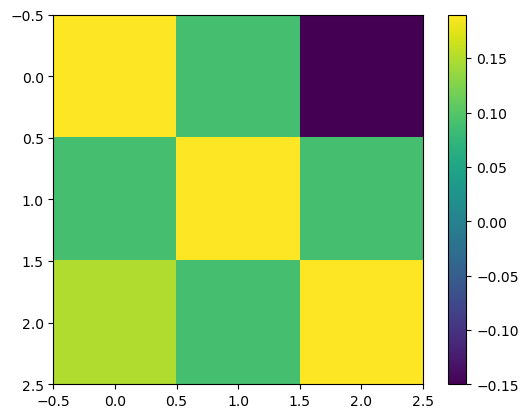

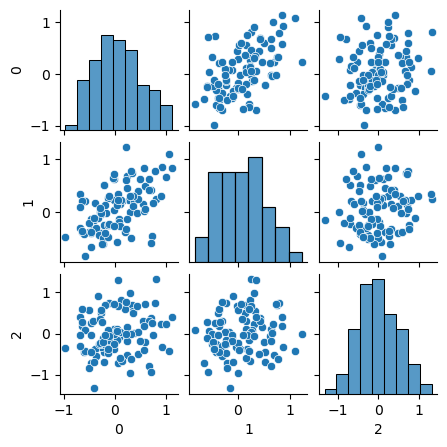

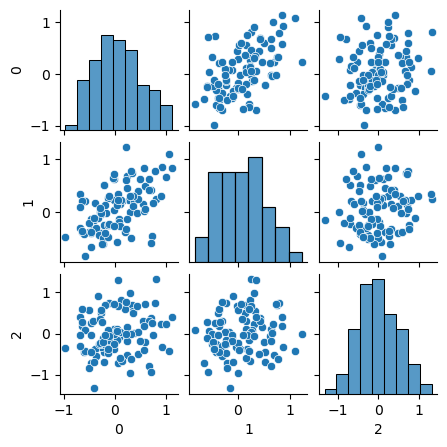

In [7]:
# Q1-2
# Step 1: Simulated data generation
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulate correlated normal data
p = 3
a_cor = (np.ones((p, p)) * 0.9 + np.diag((1, 1, 1))) / 10
a_cor[0, -1] = -0.15
a_cor[-1, 0] = 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();

sns.pairplot(pd.DataFrame(x), height=1.5)

# Transform to desired marginals
y = x.copy()
y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:, 0]))        # Gamma
y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:, 1]))     # Exponential
y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:, 2]))        # ChiSquared

sns.pairplot(pd.DataFrame(x), height=1.5)

# Step 2: Two-pass copula estimation in PyMC
import pymc as pm
import arviz as az
from scipy.stats import gamma, expon, chi2, norm

# Fit marginal distributions separately
with pm.Model() as marginals_model:
    alpha0 = pm.HalfNormal("alpha0", sigma=10)
    beta0 = pm.HalfNormal("beta0", sigma=10)
    y0 = pm.Gamma("y0", alpha=alpha0, beta=beta0, observed=y[:, 0])

    lam1 = pm.HalfNormal("lam1", sigma=10)
    y1 = pm.Exponential("y1", lam=lam1, observed=y[:, 1])

    nu2 = pm.HalfNormal("nu2", sigma=10)
    y2 = pm.ChiSquared("y2", nu=nu2, observed=y[:, 2])

    trace_marginals = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Apply PIT (Probability Integral Transform) to convert y to U[0,1]
alpha0_mean = trace_marginals.posterior["alpha0"].mean().values
beta0_mean = trace_marginals.posterior["beta0"].mean().values
lam1_mean = trace_marginals.posterior["lam1"].mean().values
nu2_mean = trace_marginals.posterior["nu2"].mean().values

u0 = gamma.cdf(y[:, 0], a=alpha0_mean, scale=1 / beta0_mean)
u1 = expon.cdf(y[:, 1], scale=1 / lam1_mean)
u2 = chi2.cdf(y[:, 2], df=nu2_mean)

# Transform U to standard normal space
z0 = norm.ppf(u0)
z1 = norm.ppf(u1)
z2 = norm.ppf(u2)

Z = np.column_stack([z0, z1, z2])

# Estimate copula using MVN model with LKJ prior
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)

    mvn = pm.MvNormal("Z", mu=np.zeros(3), chol=L, observed=Z)

    trace_copula = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


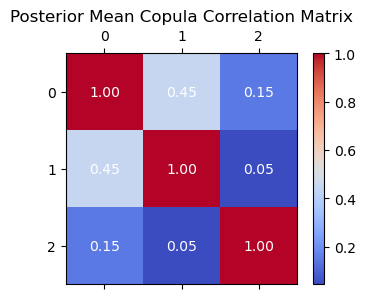

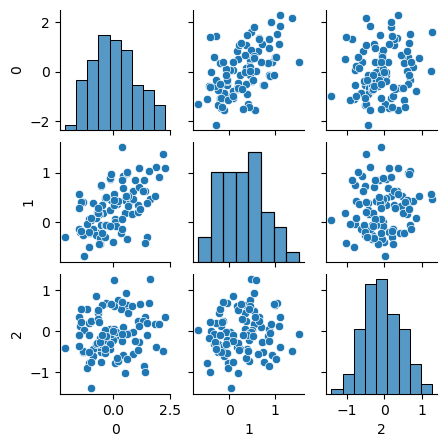

In [8]:
# Q1-2 (Remained)
import matplotlib.pyplot as plt

# Extract and visualize posterior mean correlation matrix
R_mean = trace_copula.posterior['R_corr'].mean(dim=("chain", "draw")).values

fig, ax = plt.subplots(figsize=(4, 3))
cax = ax.matshow(R_mean, cmap="coolwarm")
plt.title("Posterior Mean Copula Correlation Matrix")
fig.colorbar(cax)

# Optionally annotate values
for (i, j), val in np.ndenumerate(R_mean):
    ax.text(j, i, f"{val:.2f}", va='center', ha='center', color='white')
plt.show()

sns.pairplot(pd.DataFrame(Z), height=1.5)

# Q1-3 What a copula is and how the two verions of code implement it?

A copula is a function that captures the dependence structure between random variables independently of their marginal distributions. It allows the joint distribution to be separated into marginals and a copula function, enabling more flexible modeling of multivariate data with different types of marginals.

In the one-pass implementation, the joint model simultaneously estimates the marginals and the copula correlation by transforming each observed variable through its log CDF and standard normal inverse. While this is theoretically appealing, it results in a high-dimensional, latent-variable-rich model that is computationally intensive and often impractical due to long sampling times and convergence warnings.

In contrast, the two-pass approach first estimates the marginal distributions separately, using standard Bayesian inference for each one. The second step applies the probability integral transform (PIT) to map the observations into uniform space, then transforms them into standard normal space. These transformed values are used in a multivariate normal model with an LKJ prior to estimate the copula’s correlation structure. This version is computationally efficient, avoids the complexity of latent variables, and performs well while preserving the dependence information.

# Q1-4 How to use this to create arbitrary multivariate GLM regressions?

Copulas can be used to construct flexible multivariate GLM regressions by modeling each response variable with its own marginal regression model, and then linking their residual dependencies through a copula structure. In practice, each outcome is modeled conditionally on covariates (e.g., using appropriate GLM likelihoods like Gamma, Poisson, or Bernoulli), and the residuals or PIT-transformed variables are passed to a copula—often modeled with a multivariate normal distribution and an LKJ prior—to capture their joint dependence.

This two-stage strategy allows for arbitrary marginal regression models (with different link functions and distributions), while still capturing cross-variable correlation without assuming joint normality. It is particularly useful when modeling heterogeneous responses, such as mixing counts, skewed positive data, and binary outcomes, while maintaining coherent multivariate inference through the copula.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, slab, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 915 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


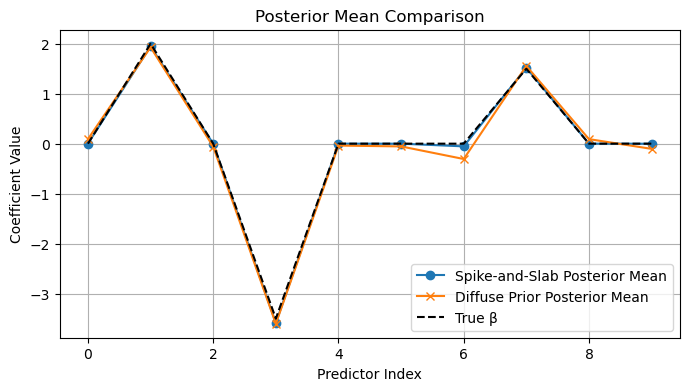

In [10]:
# Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(365)
n, p, m = 100, 10, 1  # small to keep sampling time reasonable

X = np.random.normal(0, 1, size=(n, p))
true_beta = np.zeros((p,))
true_beta[[1, 3, 7]] = [2.0, -3.5, 1.5]  # only a few true predictors
Y = X @ true_beta + np.random.normal(0, 1, size=n)

with pm.Model() as spike_slab_model: # Spike and Slab Regression
    p_incl = pm.Beta("p_incl", 1, 1)
    gamma = pm.Bernoulli("gamma", p=p_incl, shape=p)
    
    slab = pm.Normal("slab", mu=0, sigma=10, shape=p)
    beta = pm.Deterministic("beta", gamma * slab)
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.math.dot(X, beta)
    
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    idata_slab = pm.sample(1000, tune=1000, return_inferencedata=True)
    
with pm.Model() as normal_prior_model: # Diffuse Normal Prior Regression (L2 style)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=p)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.math.dot(X, beta)
    
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    idata_normal = pm.sample(1000, tune=1000, return_inferencedata=True)

# Posterior mean of beta for both models
beta_spike = az.summary(idata_slab, var_names=["beta"])["mean"].values
beta_normal = az.summary(idata_normal, var_names=["beta"])["mean"].values

# Plot comparison
plt.figure(figsize=(8,4))
plt.plot(beta_spike, label="Spike-and-Slab Posterior Mean", marker='o')
plt.plot(beta_normal, label="Diffuse Prior Posterior Mean", marker='x')
plt.plot(true_beta, label="True β", linestyle='--', color='k')
plt.legend()
plt.xlabel("Predictor Index")
plt.ylabel("Coefficient Value")
plt.title("Posterior Mean Comparison")
plt.grid(True)
plt.show()

# Q2
To reduce computational demands, we limited the data size to n = 100, p = 10, and m = 1. This setup allows efficient sampling while retaining enough structure to compare spike-and-slab regression with diffuse prior inference. When scaling to larger datasets, the computational cost increases along several key dimensions:

n (number of observations): Larger n leads to more likelihood evaluations per MCMC iteration, directly increasing runtime.

m (number of response variables): When modeling multivariate outputs, increasing m adds complexity to the likelihood and often requires additional covariance modeling, which significantly increases computational demands.

p (number of predictors): For spike-and-slab models, increasing p adds one binary inclusion variable and one slab coefficient per predictor, expanding the parameter space and making inference slower and more challenging to converge.

In our experiment, the spike-and-slab model accurately selected the true predictors, while the diffuse normal prior estimated all coefficients but lacked sparsity. However, as p grows large, the spike-and-slab model becomes computationally expensive, making it more suitable for moderate p or situations where variable selection is critical.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



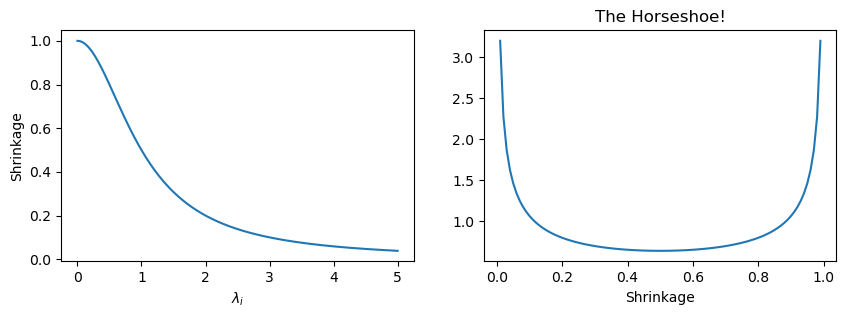

In [160]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

# Q3 Variable Selection with the Horseshoe Prior

The **horseshoe prior** is a sparsity-inducing prior used for variable selection, similar in purpose to the spike-and-slab prior but implemented with continuous shrinkage. It combines strong shrinkage of irrelevant coefficients with minimal shrinkage of large signals. In contrast to the binary inclusion structure in spike-and-slab, the horseshoe uses a hierarchical structure of continuous scale parameters.

We implemented a linear regression model using the horseshoe prior for the regression coefficients and compared it to the previous spike-and-slab model. The prior takes the form:

$[
\beta_j \sim \mathcal{N}(0, \lambda_j^2 \tau^2), \quad \lambda_j \sim \text{HalfCauchy}(1), \quad \tau \sim \text{HalfCauchy}(1)
$]

This allows most $(\beta_j$) to be heavily shrunk toward zero while allowing a few to escape shrinkage when $(\lambda_j$) is large.


In [12]:
# Q3
import pymc as pm
import numpy as np

np.random.seed(365)
n, p = 100, 10
X = np.random.normal(0, 1, size=(n, p))
true_beta = np.zeros(p)
true_beta[[1, 3, 7]] = [2.0, -3.5, 1.5]
Y = X @ true_beta + np.random.normal(0, 1, size=n)

with pm.Model() as horseshoe_model:
    tau = pm.HalfCauchy("tau", beta=1)
    lam = pm.HalfCauchy("lam", beta=1, shape=p)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=p)
    mu = pm.math.dot(X, beta)
    
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    idata_hs = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lam, sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.


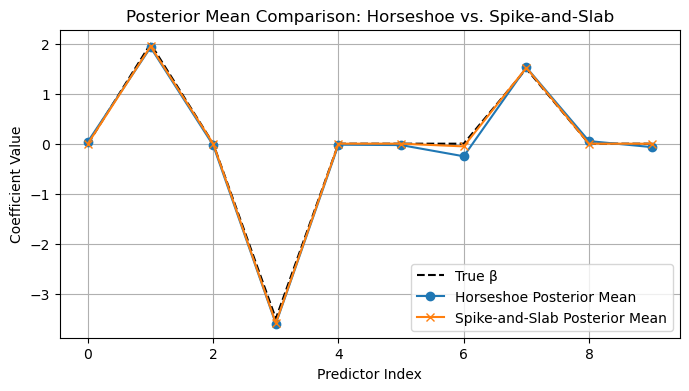

In [15]:
# Q3 (Remained)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# True beta used in simulation
true_beta = np.zeros(10)
true_beta[[1, 3, 7]] = [2.0, -3.5, 1.5]

# Posterior means of beta from horseshoe model
beta_hs = az.summary(idata_hs, var_names=["beta"])["mean"].values

# Posterior means from spike-and-slab model (make sure idata_slab exists)
beta_slab = az.summary(idata_slab, var_names=["beta"])["mean"].values

# Plot comparison
plt.figure(figsize=(8, 4))
plt.plot(true_beta, label="True β", linestyle="--", color="black")
plt.plot(beta_hs, label="Horseshoe Posterior Mean", marker="o")
plt.plot(beta_slab, label="Spike-and-Slab Posterior Mean", marker="x")
plt.xlabel("Predictor Index")
plt.ylabel("Coefficient Value")
plt.title("Posterior Mean Comparison: Horseshoe vs. Spike-and-Slab")
plt.legend()
plt.grid(True)
plt.show()